# Projet OPA

## Partie 3 : Consomation des Données

### Objectif du Document:

Ce doc a pour but de présenter les différentes étapes pour : 
- Calculer un Modéle Classification ML de prédiction Vente / Achat

### Step 1:  Initialisation des Modules

In [1]:
from Binance.Data import Binance_Histo as Histo
from Binance.Data import Binance_Live as live
from Binance.Dao import Drivers_MongoDB as DAO_MB
from Binance.Dao import Drivers_SQlite as DAO_SQL
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from Binance.Utils import ML_Classification as ML

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Création DataFrame des Données Test / Entrainement
def CreateDataFrame(SQLScript, limite = -1) :
    
    res = SQL.Select(SQLScript, (limite,))

    L = list()
    for i in res:
        (a, b, c, d, e, f, g, h, i, j) = i
        L.append({'id_temps' : a,
                 'cours' : b, 
                 'DEC_ACHAT' : c, 
                 'DEC_VENTE' : d ,
                 'ID_SIT_CRS_HIS' :e ,
                 'IND_STOCH_RSI' : f,
                 'IND_RSI' : g,
                 'IND_TRIX' : h,
                 'TOP_ACHAT' : i,
                 'TOP_VENTE' : j})

    return pd.DataFrame(L)

# Affichage des Données ( Valeurs Cours, ainsi que les décisions d'achat / vente )
def AffichageGraphe(df, limite = 300):
    
    df_temps = df.iloc[:limite]
    
    plt.figure(figsize= (10,10))
    plt.plot(df_temps.id_temps, df_temps.cours, label = 'Valeurs Cours')
    plt.scatter(df_temps[df_temps['DEC_ACHAT'] != 0].id_temps, df_temps[df_temps['DEC_ACHAT'] != 0].DEC_ACHAT ,linewidths= 5,c ='r', marker='^', label = 'Decison Achat')
    plt.scatter(df_temps[df_temps['DEC_VENTE'] != 0].id_temps, df_temps[df_temps['DEC_VENTE'] != 0].DEC_VENTE,linewidths= 5, c ='y', marker='v', label = 'Decison Vente')

    plt.legend()


### Step 2 : Connection à la base SQLite

In [2]:
PathDatabase = '/home/arnold/ENV_VIRTUEL/ATU_FORMATION/REP_DEV/Projet_OPA/DataBase/SQLite/test.db'
SQL = DAO_SQL.Drivers_SQLite(PathDatabase)

### Step 3 : Création Jeux Données Entrainement ML

In [4]:
sqlscript_Train ="""select datetime(A.id_temps/1000,'unixepoch'), 
    VALEUR_COURS, 
    VALEUR_COURS * B_A.IND_DEC, 
    VALEUR_COURS * B_V.IND_DEC,
    A.ID_SIT_CRS_HIS,
    IND_STOCH_RSI,
    IND_RSI,
    IND_TRIX,
    B_A.IND_DEC, 
    B_V.IND_DEC
    from FAIT_SIT_COURS_HIST A
    inner join FAIT_DEC_ML_CLASS B_A ON (B_A.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_A.ID_MLCLAS = 3)
    inner join FAIT_DEC_ML_CLASS B_V ON (B_V.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_V.ID_MLCLAS = 4)
    inner join DIM_TEMPS C ON (C.ID_TEMPS = A.ID_TEMPS)
    where IND_STOCH_RSI is not null and IND_RSI is not null and IND_TRIX is not null and C.ANNEE in ('2020')
    limit ?;"""


In [5]:
# Création du DataFrame Entrainement
df = CreateDataFrame(sqlscript_Train)

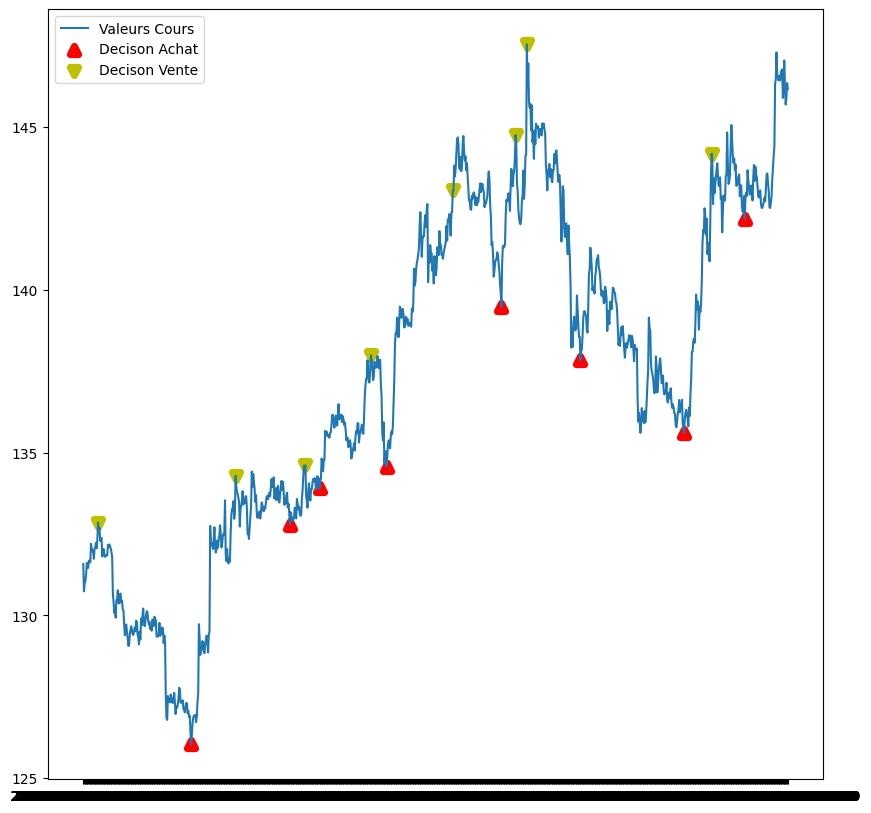

In [6]:
#Affichage Graphe des 1000 premiers Cours ainsi que les decisisions d'Achat
AffichageGraphe(df,1000)

### Step 4 : Création du modéle ML avec l'algo Classification
puis Calcul Classification Achat / Vente

In [7]:

df['ID_SIT_CRS'] = df['ID_SIT_CRS_HIS']

ML_Class = ML.ML_CLassification(df)


### Step 5 : Prédiction Model sur un Jeu Réel

#### Step 5.1 : Résulat Prédiction

In [8]:
sqlscript_Test = """select datetime(A.id_temps/1000,'unixepoch'), 
    VALEUR_COURS, 
    VALEUR_COURS * B_A.IND_DEC, 
    VALEUR_COURS * B_V.IND_DEC,
    A.ID_SIT_CRS_HIS,
    IND_STOCH_RSI,
    IND_RSI,
    IND_TRIX,
    B_A.IND_DEC, 
    B_V.IND_DEC
    from FAIT_SIT_COURS_HIST A
    inner join FAIT_DEC_ML_CLASS B_A ON (B_A.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_A.ID_MLCLAS = 3)
    inner join FAIT_DEC_ML_CLASS B_V ON (B_V.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_V.ID_MLCLAS = 4)
    inner join DIM_TEMPS C ON (C.ID_TEMPS = A.ID_TEMPS)
    where IND_STOCH_RSI is not null and IND_RSI is not null and IND_TRIX is not null and C.ANNEE = '2021'
    limit ?; """


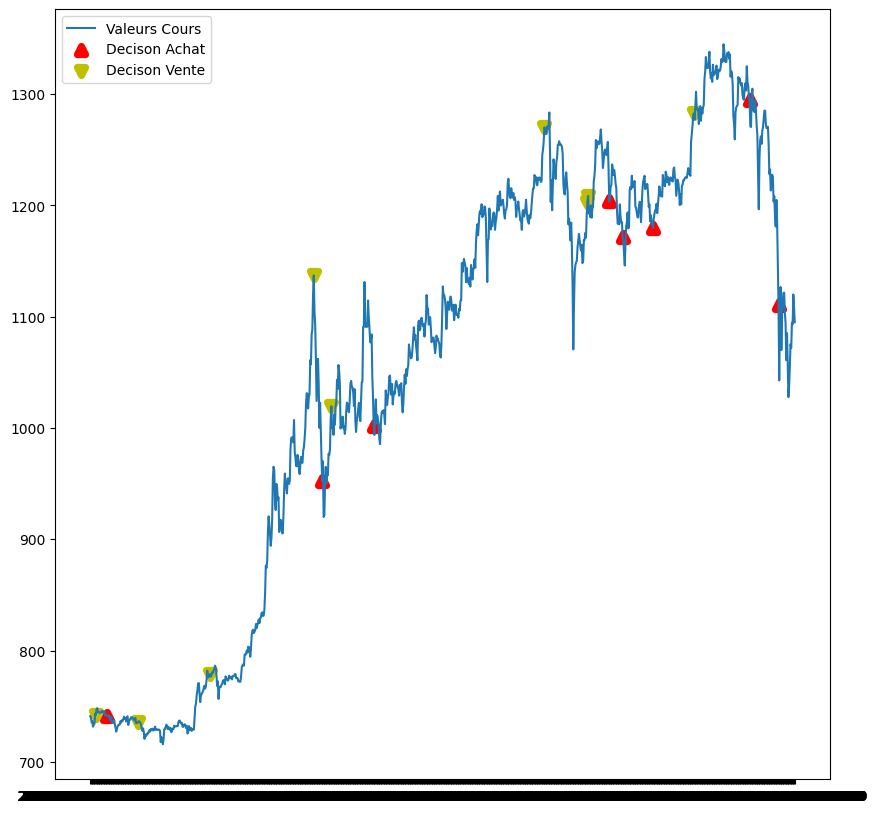

In [9]:
df_test = CreateDataFrame(sqlscript_Test)
df_test['ID_SIT_CRS'] = df_test['ID_SIT_CRS_HIS']

df_test = pd.concat([ML_Class.predict(df_test), df_test[['id_temps','cours']], ], axis = 1)

df_test['DEC_ACHAT'] = df_test['cours'] * df_test['TOP_ACHAT']
df_test['DEC_VENTE'] = df_test['cours'] * df_test['TOP_VENTE']

# Prévision sur les 2000 premiers cours
AffichageGraphe(df_test, 1000)

#### Step 5.2 : Résulat attendu

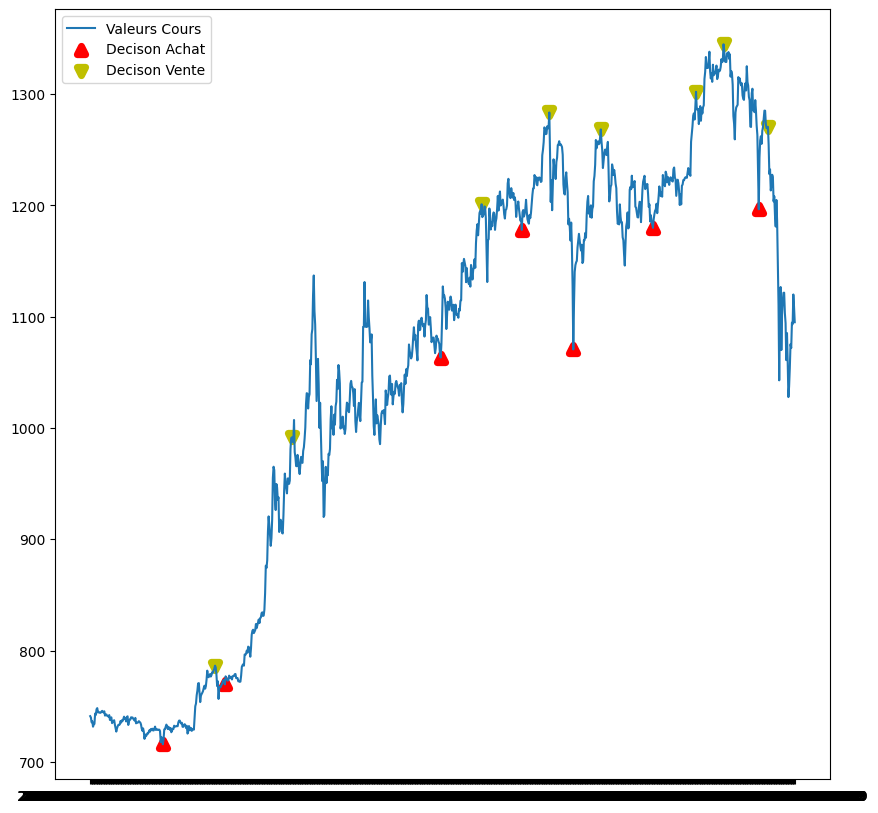

In [10]:
# Prévision Rélle attendue sur les 2000 premiers cours
df_reel = CreateDataFrame(sqlscript_Test)
AffichageGraphe(df_reel,1000)